# Data Gathering

Next Steps:  
1. Transform .las files from USFT to LatLon
2. Transfer over to Spark on Databricks (https://rasterframes.io/vector-data.html)

In [56]:
import geopandas as gp
import os
import numpy as np
from laspy.file import File
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

## Data sources

In [39]:
# Find SRC codes here: https://spatialreference.org/
# SRC code for lidar found here: https://prd-tnm.s3.amazonaws.com/LidarExplorer/index.html#/
# Another SRC code for lidar: https://epsg.io/102673
# INDIANA EAST ZONE FIPSZONE: 1301 ADSZONE: 3826 UTM ZONE: 16
# CONVERSION TOOL: https://www.ngs.noaa.gov/NCAT/

# LiDAR metadata soure: https://www.dropbox.com/sh/ft35dwy9m5qe9f1/AACXW_W_DoWDiHeOUh00tAzja/2016%20Marion%20County?dl=0&subfolder_nav_tracking=1

url_lidar = 'https://lidar.jinha.org/download.php?cname=marion&clon=-86.13305839196093&clat=39.779844384833936&years=2011,2016'
url_vacant_and_abandoned_dataset = 'https://data.indy.gov/datasets/abandoned-and-vacant-housing?geometry=-86.313%2C39.748%2C-85.983%2C39.794'

In [40]:
# CRS code for the input .las files
crs_input = 'ESRI:102673'

# Desired format
crs_lat_lon = 'EPSG:4326'

## Load geo-data on abandoned and vacant buildings

In [41]:
# Abandoned building data is stored here
base_path = './training_data/abandoned_and_vacant/'

# Abandoned building shapefile
gdf_abandoned = gp.read_file(base_path + 'Abandoned_And_Vacant_Housing.shp', crs='EPSG:4326')

print(gdf_abandoned.shape)
gdf_abandoned.head()

(7216, 15)


,OBJECTID,PARCEL_I,STNUMBER,PRE_DIR,STREET_NAM,SUFFIX,SUF_DIR,FULL_STNAM,CITY,ZIPCODE,ADDRESS,STATUS,SHAPEAREA,SHAPELEN,geometry
0,345944,1029867,2365,None,ADAMS,ST,None,ADAMS ST,INDIANAPOLIS,46218,2365 ADAMS ST,Abandoned,12801.863622,480.073502,"POLYGON ((-86.10858 39.80163, -86.10858 39.801..."
1,346056,1010458,2755,N,KEYSTONE,AVE,None,KEYSTONE AVE,INDIANAPOLIS,46218,2755 N KEYSTONE AVE,Abandoned,11133.172761,434.607365,"POLYGON ((-86.12098 39.80677, -86.12146 39.806..."
2,346078,1088338,1929,None,HOUSTON,ST,None,HOUSTON ST,INDIANAPOLIS,46218,1929 HOUSTON ST,Abandoned,5400.130625,350.010293,"POLYGON ((-86.10891 39.79337, -86.10891 39.793..."
3,346248,1024949,40,None,EASTERN,AVE,None,EASTERN AVE,INDIANAPOLIS,46201,40 EASTERN AVE,Abandoned,4999.768822,329.991105,"POLYGON ((-86.11771 39.76975, -86.11816 39.769..."
4,346265,1014955,1031,N,TACOMA,AVE,None,TACOMA AVE,INDIANAPOLIS,46201,1031 N TACOMA AVE,Abandoned,6405.338407,436.020670,"POLYGON ((-86.11886 39.78222, -86.11951 39.782..."


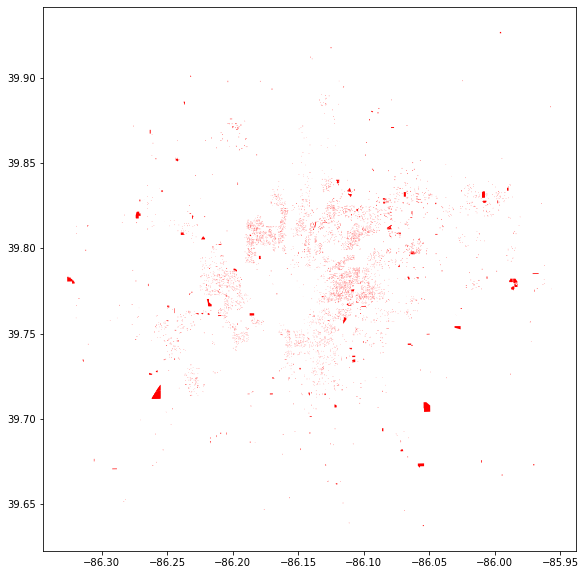

In [79]:
# Map the abandoned properties
f, ax = plt.subplots(figsize=(15,10))

gdf_abandoned.plot(ax=ax, color='red');

## Load the lidar data for Indianapolis, IN

In [4]:
# Lidar satellite data
las_files = [f for f in os.listdir('./training_data/las_files/') if f[0]!='.']

las_files

['MC_01951645.las',
 'MC_01951650.las',
 'MC_01951640.las',
 'MC_02051640.las',
 'MC_02051650.las',
 'MC_02051645.las',
 'MC_02001645.las',
 'MC_02001650.las',
 'MC_02001640.las']

In [62]:
def las_to_geodf(filename, crs=None):
    '''Convert an .las file to a Geopandas Geodataframe object.'''

    print('Trying file', filename, '\n')
    usft_to_meter = 0.30480060960121924
    base_path = './training_data/las_files/'

    #Read LAS file
    try:
        inFile = File(base_path + filename)
        print('inFile accepted.')
    except:
        print(filename, " failed.")
        return None

    #Import LAS into numpy array
    lidar_points = np.array((inFile.x*usft_to_meter,
                             inFile.y*usft_to_meter,
                             inFile.z*usft_to_meter,
                             inFile.intensity,
                             inFile.classification)).transpose()
    print('information accepted.')

    #Transform to geopandas GeoDataFrame
    lidar_geodf = gp.GeoDataFrame(lidar_points, geometry = gp.points_from_xy(inFile.x, inFile.y), crs=crs)
    lidar_geodf.rename(columns = {0:'x', 1:'y', 2:'z', 3:'intensity', 4:'classification'}, inplace=True)
    print('points accepted.')

    print(filename, " successful.\n")
    inFile.close()

    return lidar_geodf

In [5]:
def merge_geodfs(geodfs):
  result_gdf = geodfs[0]
  for gdf in geodfs[1:]:
    result_gdf = result_gdf.append(gdf).reset_index(drop=True)
  return result_gdf

In [27]:
gdf = las_to_geodf(las_files[0], crs=crs_input)
gdf

Trying file MC_01951645.las 

inFile accepted.
information accepted.
points accepted.
MC_01951645.las  successful.



,x,y,z,intensity,classification,geometry
0,60350.502413,502919.957328,227.442215,9216.0,1.0,POINT (197999.940 1649996.560)
1,60349.307595,502920.880874,227.518415,11264.0,1.0,POINT (197996.020 1649999.590)
2,60349.386843,502919.835408,227.454407,7424.0,1.0,POINT (197996.280 1649996.160)
3,60349.469139,502918.786894,227.426975,8704.0,2.0,POINT (197996.550 1649992.720)
4,60349.816612,502920.192024,238.101092,3584.0,1.0,POINT (197997.690 1649997.330)
...,...,...,...,...,...,...
11299799,60359.372111,502920.917450,235.046990,15104.0,1.0,POINT (198029.040 1649999.710)
11299800,60357.409195,502920.963170,227.539751,8448.0,1.0,POINT (198022.600 1649999.860)
11299801,60355.019558,502920.883922,239.369063,2560.0,1.0,POINT (198014.760 1649999.600)
11299802,60353.724155,502920.990602,240.423673,1536.0,1.0,POINT (198010.510 1649999.950)


In [28]:
gdf_4326 = gdf.loc[:, ['intensity', 'geometry']].to_crs(crs_lat_lon)
gdf_4326

,intensity,geometry
0,9216.0,POINT (-86.12949 39.77753)
1,11264.0,POINT (-86.12951 39.77754)
2,7424.0,POINT (-86.12951 39.77753)
3,8704.0,POINT (-86.12950 39.77752)
4,3584.0,POINT (-86.12950 39.77754)
...,...,...
11299799,15104.0,POINT (-86.12939 39.77754)
11299800,8448.0,POINT (-86.12941 39.77754)
11299801,2560.0,POINT (-86.12944 39.77754)
11299802,1536.0,POINT (-86.12945 39.77754)


In [80]:
# Boundaries for the LiDAR tile
x_min, x_max, y_min, y_max = -86.14016495696444, -86.12228581315563, 39.76377561875412, 39.777572323113745

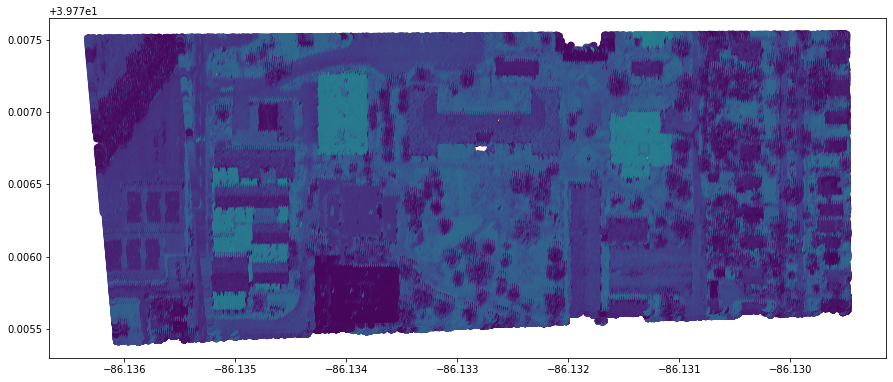

In [60]:
gdf_4326.plot('intensity', figsize=(15,15));

___

In [141]:
# Runtime: 27 minutes

# Convert all las files to geodataframes
# lidar_geodfs = [las_to_geodf(filename) for filename in las_files]

Trying file MC_01951645.las 

inFile accepted.
information accepted.
points accepted.
MC_01951645.las  successful.

Trying file MC_01951650.las 

inFile accepted.
information accepted.
points accepted.
MC_01951650.las  successful.

Trying file MC_01951640.las 

inFile accepted.
information accepted.
points accepted.
MC_01951640.las  successful.

Trying file MC_02051640.las 

MC_02051640.las  failed.


UnboundLocalError: local variable 'inFile' referenced before assignment

Failed:  
MC_02051640.las  
MC_02001645.las  
MC_02001640.las

In [14]:
# Runtime: 16 minutes

# Create a single geodataframe
# lidar_geodf = merge_geodfs(lidar_geodfs)

In [15]:
# lidar_geodf

,x,y,z,intensity,classification,scan_angle,geometry
0,197999.94,1649996.56,746.20,9216.0,1.0,-2167.0,POINT Z (197999.940 1649996.560 746.200)
1,197996.02,1649999.59,746.45,11264.0,1.0,-2167.0,POINT Z (197996.020 1649999.590 746.450)
2,197996.28,1649996.16,746.24,7424.0,1.0,-2167.0,POINT Z (197996.280 1649996.160 746.240)
3,197996.55,1649992.72,746.15,8704.0,2.0,-2167.0,POINT Z (197996.550 1649992.720 746.150)
4,197997.69,1649997.33,781.17,3584.0,1.0,-2167.0,POINT Z (197997.690 1649997.330 781.170)
...,...,...,...,...,...,...,...
10411270,204000.18,1650006.02,765.63,13824.0,1.0,3000.0,POINT Z (204000.180 1650006.020 765.630)
10411271,204000.03,1650000.53,777.74,1280.0,1.0,3000.0,POINT Z (204000.030 1650000.530 777.740)
10411272,204000.12,1650004.54,765.58,12288.0,1.0,3000.0,POINT Z (204000.120 1650004.540 765.580)
10411273,204000.07,1650003.08,765.45,14336.0,2.0,3000.0,POINT Z (204000.070 1650003.080 765.450)


Resulting dataframe is:  
64464045 rows × 7 columns

## Visualize

In [ ]:
gdf_4326.plot('intensity', figsize=(15,15));

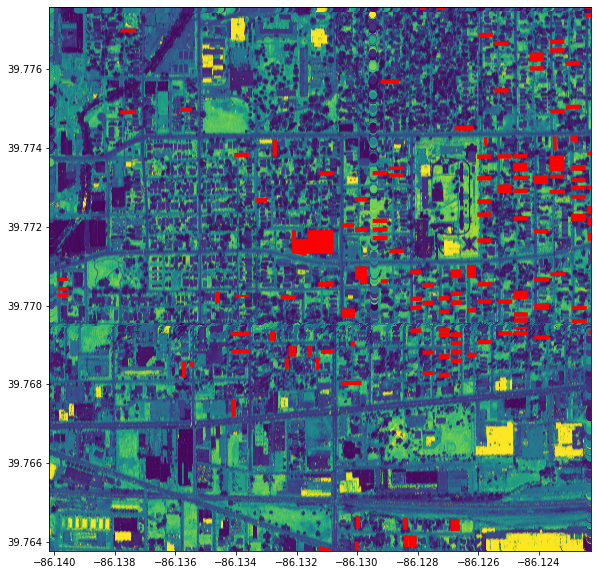

In [82]:
# Map the abandoned properties over the satelite image
f, ax = plt.subplots(figsize=(15,10))

gdf_4326.plot('intensity', ax=ax)
gdf_abandoned.plot(ax=ax, color='red')
ax.set_xlim(left=x_min, right=x_max)
ax.set_ylim(bottom=y_min, top=y_max);

In [ ]:
lidar_small = lidar_geodf.loc[:, ['intensity', 'geometry']].copy()

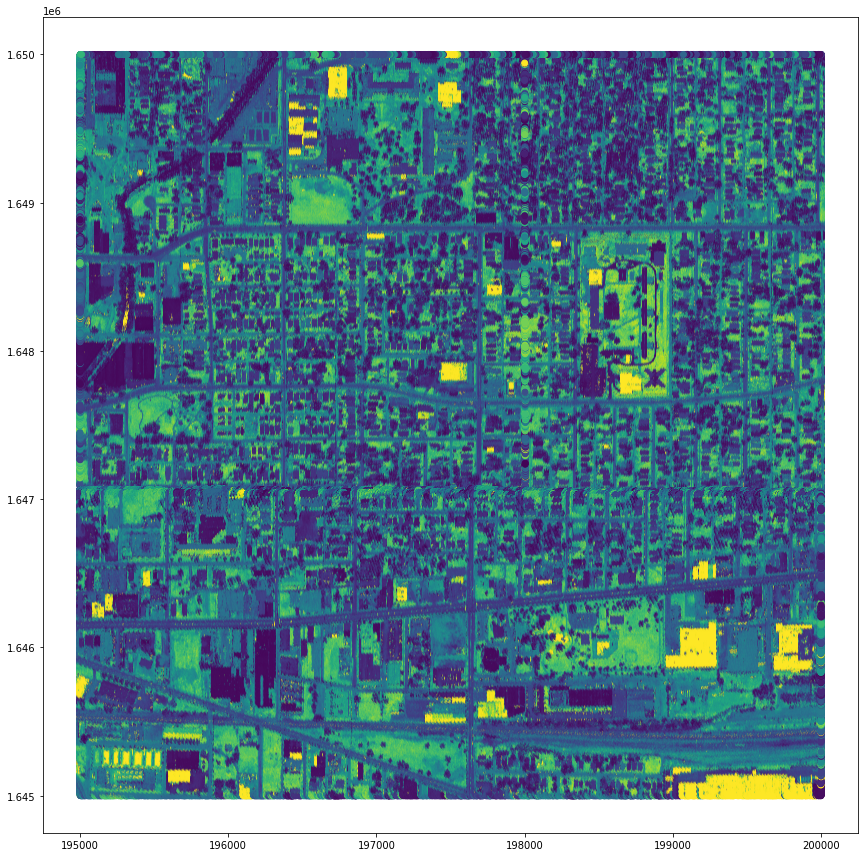

In [14]:
lidar_geodf.plot('intensity', figsize=(15,15));